<a href="https://colab.research.google.com/github/SaKi1309/MasterthesisVolograms/blob/master/VologramsData_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a name="0"></a>
# 0. Initial steps

<a name="0-1"></a>
## 0.1 Mount your drive

Please run the next code cell and follow these steps to mount your Google Drive so that it can be accessed by this Colab.
- Run the code cell below.  A web link will appear below the cell.
- Please click on the web link, which will open a new tab in your browser, which asks you to choose your google account.
- Choose your google account to login.
- The page will display "Google Drive File Stream wants to access your Google Account".  Please click "Allow".
- The page will now show a code (a line of text).  Please copy the code and return to this Colab.
- Paste the code the textbox that is labeled "Enter your authorization code:" and hit `<Enter>`
- The text will now say "Mounted at /content/drive/"

In [159]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


<a name="1"></a>
# 1. Environment

<a name="1-1"></a>
## 1.1 Importing Libraries

In [307]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#import tensorflow_datasets as tfds
import os
import cv2
from tqdm import tqdm
import tensorflow_addons as tfa

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.0


<a name="1-2"></a>
## 1.2 Distribution Strategy - HW Detection
Depending on the hardware available, different distribution strategies will be applied.

- If the TPU is available, the TPU Strategy is used.
Otherwise:
- If more than one GPU is available, then the Mirrored Strategy is applied
- If one GPU is available or if just the CPU is available, the default strategy is applied.

In [250]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on CPU
Number of accelerators:  1


<a name="1-3"></a>
## 1.3 Global Parameters

In [308]:
DATA_PATH_SYNTHETIC = os.path.join("/content","drive","My Drive","DatasetVolograms", "Synthetic_Data_Samples")
DATA_PATH_TARGET = os.path.join("/content","drive","My Drive","DatasetVolograms", "Target_Data_Samples")

# The global batch size is the batch size per replica (1 in this case) times the number of replicas in the distribution strategy (In Colab: 8 for TPU, 1 for GPU and CPU).
BATCH_SIZE = 1
GLOBAL_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync

# Used for the data piple to feed the data to the network
BUFFER_SIZE = 256

# RGBD Image: Height = Width = 512, Channel: Red, Green, Blue, Depth
IMG_SIZE = (512,512,4)

# Weights initializer for the layers.
KERNEL_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

# Gamma initializer for instance normalization.
GAMMA_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

#autotune function for parallelism.
AUTOTUNE = tf.data.experimental.AUTOTUNE

<a name="2"></a>
# 2. Utilities and Helper Functions

In [ ]:
#Remove _RGB_ and _DEPTH_ from the file names to ensure same naming...
def Prepare_filename(directory):
    for filename in os.listdir(directory):
        #os.rename(os.path.join(directory, filename), os.path.join(directory, newFilename))
        if "_RGB_" in filename:
            newFilename = filename.replace("_RGB_","_")
            os.rename(os.path.join(directory, filename), os.path.join(directory, newFilename))
        elif "_DEPTH_" in filename:
            newFilename = filename.replace("_DEPTH_","_")
            os.rename(os.path.join(directory, filename), os.path.join(directory, newFilename))

In [330]:
#loads RGB and DEPTH images and combines them into one RGBD Dataset. Shape (sample, Height, Width, Channel). Channel: R,G,B,D
def Combine_color_depth(directory):
    
    #get list from all filenames without file extension. Note that RGB and EXR need to have the same name!
    fileNames = [".".join(f.split(".")[:-1]) for f in os.listdir(directory)]
    
    #Hack to remove duplicates from List
    fileNames = list(dict.fromkeys(fileNames))
    
    numberOfFiles = len(fileNames)

    #empty array container
    combined = np.zeros(shape = (numberOfFiles, 512, 512, 4), dtype=float)

    #setup progressbar
    pbar = tqdm(total=numberOfFiles, position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
    

    for i in range(0, numberOfFiles):
        currentFile = os.path.join(directory,fileNames[i])
        image = cv2.imread(currentFile + '.png')[:,:,::-1] #OPEN CV reads images in BGR not in RGB!!!!
        depth = cv2.imread(currentFile + '.exr', cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

        #print("Iteration {} of {}: Image = {},  Depth = {}".format(i, numberOfFiles, image.shape, depth.shape))
        
        image = image/255;
        depth = depth/5;
        
        combined[i,:,:,0:3] = image
        combined[i,:,:,3] = depth

        pbar.set_description("Load images") #works better if set in every loop! 
        pbar.update()

    #print("Combined = {}".format(combined.shape))
    
    return combined

In [338]:
def Create_tensorflow_dataset(data, trainSplit = None):
    '''
    Creates a dataset from a numpy tensor.

    Params:  
      1. data: Numpy array
      2. trainSplit: float between 0...1 or None. If None, complete data will be returned as dataset. If float, a training and a testset will be returned according the ratio
    '''

    numberOfSamples = data.shape[0]
    
    if trainSplit == None:
      dataset = tf.data.Dataset.from_tensor_slices(data)
      print("\nDataset created. Total samples: {}, training split: None".format(numberOfSamples))
      return dataset
    else:
      assert trainSplit <= 1.0 and trainSplit >=0 , "trainSplit needs to be a float between 0...1"
      train_size = int(trainSplit * numberOfSamples)
      train = tf.data.Dataset.from_tensor_slices(data[:train_size,...])
      test = tf.data.Dataset.from_tensor_slices(data[train_size:,...])
      

      print("\nDataset created. Total samples: {}, training split: {}, training samples: {}, test samples: {}".format(numberOfSamples, trainSplit, train_size, numberOfSamples-train_size))
      return [train, test]
    
    
    
    #print(dataset)
    #dataset = dataset.take(3)
    #print(list(dataset.as_numpy_iterator()))


    #path = os.path.join("Datasets","dataset")
    #tf.data.experimental.save(dataset, path)
   # new_dataset = tf.data.experimental.load(path, tf.TensorSpec(shape=(30,512,512,4), dtype=tf.float32))

    #new_dataset = dataset.take(3)
    #print(list(new_dataset.as_numpy_iterator()))
    #print(new_dataset)
    

In [311]:
def Plot_RGBD_Sample(rgbd, title = "RGBD Plot"):
    fig = plt.figure()
    fig.suptitle(title, fontsize=16)
    ax = fig.add_subplot(1, 2, 1)
    imgplot = plt.imshow(rgbd[:,:,0:3])
    ax.set_title('RGB')
    #plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
    ax = fig.add_subplot(1, 2, 2)
    imgplot = plt.imshow(rgbd[:,:,3])
    #imgplot.set_clim(0.0, 0.7)
    ax.set_title('Depth')
    #plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7])
    plt.show()

def Plot_Multiple_RGBD(rgbd_samples, count = 6):
    fig = plt.figure(figsize=[20,20])
    samplesToPlot = min(rgbd_samples.shape[0], count)
    for i in range(0, samplesToPlot):
        ax = fig.add_subplot(3, 4, i*2+1)
        imgplot = plt.imshow(rgbd_samples[i,:,:,0:3])
        ax.set_title('RGB')
        #plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
        ax = fig.add_subplot(3, 4, i*2+2)
        imgplot = plt.imshow(rgbd_samples[i,:,:,3])
        #imgplot.set_clim(0.0, 0.7)
        ax.set_title('Depth')
        #plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7])
    plt.show()

<a name="3"></a>
# 3. Preparing the Data

<a name="3-1"></a>
## 3.1 Prepare Dataset

Load images: 100%|██████████| 30/30 
Load images: 100%|██████████| 30/30 


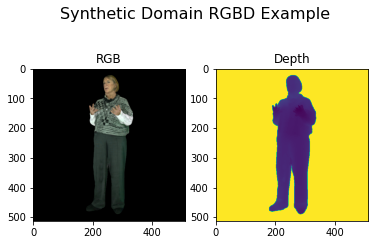

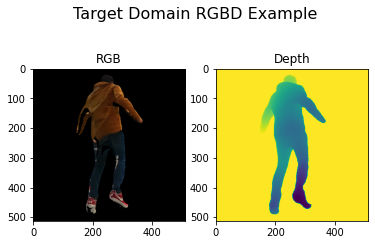

In [332]:
#Load data, and inspect examples
rgbd_synthetic = Combine_color_depth(DATA_PATH_SYNTHETIC)
rgbd_target = Combine_color_depth(DATA_PATH_TARGET)
Plot_RGBD_Sample(rgbd_synthetic[0,...], "Synthetic Domain RGBD Example")
Plot_RGBD_Sample(rgbd_target[0,...], "Target Domain RGBD Example")

In [363]:
#Create Tensorflow Datasets and split into training and test sets. 
train_synthetic, test_synthetic = Create_tensorflow_dataset(rgbd_synthetic, trainSplit = 0.8)
train_target, test_target = Create_tensorflow_dataset(rgbd_target, trainSplit = 0.8)


Dataset created. Total samples: 30, training split: 0.8, training samples: 24, test samples: 6

Dataset created. Total samples: 30, training split: 0.8, training samples: 24, test samples: 6


<a name="3-2"></a>
## 3.2 Define Preprocessing

To check:


1.   Werden bei dataaugmentation wirklich neue samples erzeugt, oder werden einfach nur die batches jedes mal neu geshuffelt zund somit ist in jeder epoche die Daten anders?

2.   Checken wie ich die depth daten am besten normalisiere... in den synthetischen ist der max value 5, der background. Die daten von der target domain kenne ich noch nicht... 


Tensorflow Image API: https://www.tensorflow.org/api_docs/python/tf/image

Guide for Data Augmentation here: https://www.tensorflow.org/tutorials/images/data_augmentation

API for using Keras Layers for augmentation!: https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing



---

Ggf. muss ich das image splitten in RGB und D bevor ich es preprozesse, da viele sachen nur für RGB...



In [364]:
def Normalize_Image(img):
  # TODO: Implement!
  #img = tf.cast(img, dtype=tf.float32)
  #img[:,:,:3] /= 255  #first 3 Channel are RGB values, with 8bit, therfore normalize to 0...1
  #img[:,:,3:] /= 5
  return img

In [365]:
def Augmentate_Data(img):
  # Random flip
  img = tf.image.random_flip_left_right(img)
  return img

In [366]:
@tf.function
def Preprocess_Train_Data(img):
  img = Augmentate_Data(img)
  img = Normalize_Image(img)
  return img

In [367]:
@tf.function
def Preprocess_Test_Data(img):
  img = Normalize_Image(img)
  return img

<a name="3-3"></a>
## 3.3 Define Dataset Pipeline

Information to applied functions here: https://www.tensorflow.org/api_docs/python/tf/data/Dataset

IMPORTANT: Call Can only be run once in Colab.... after that, the dataset needs to be created newly. 

In [368]:
train_synthetic = (
    train_synthetic.map(Preprocess_Train_Data, num_parallel_calls=AUTOTUNE)
    .shuffle(BUFFER_SIZE)
    .batch(GLOBAL_BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
train_sythetic_distributed = strategy.experimental_distribute_dataset(train_sythetic)

train_target = (
    train_synthetic.map(Preprocess_Train_Data, num_parallel_calls=AUTOTUNE)
    .shuffle(BUFFER_SIZE)
    .batch(GLOBAL_BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
train_target_distributed = strategy.experimental_distribute_dataset(train_target)

test_synthetic = (
    train_synthetic.map(Preprocess_Test_Data, num_parallel_calls=AUTOTUNE)
    .shuffle(BUFFER_SIZE)
    .batch(GLOBAL_BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
test_sythetic_distributed = strategy.experimental_distribute_dataset(test_sythetic)

test_target = (
    train_synthetic.map(Preprocess_Test_Data, num_parallel_calls=AUTOTUNE)
    .shuffle(BUFFER_SIZE)
    .batch(GLOBAL_BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
test_target_distributed = strategy.experimental_distribute_dataset(test_target)


<a name="4"></a>
# 4. Defining the Model

Usefull Links:


*   Layer API: https://www.tensorflow.org/api_docs/python/tf/keras/layers
*   Model API: https://www.tensorflow.org/api_docs/python/tf/keras/Model
*   Tensorflow AdOns API: https://www.tensorflow.org/addons/api_docs/python/tfa 
*   Tensor Flow Dataset API (not tfds!): https://www.tensorflow.org/api_docs/python/tf/data/Dataset


---




Hint from TensorFlow Documentation (https://www.tensorflow.org/guide/keras/custom_layers_and_models):

"*In general, you will use the Layer class to define inner computation blocks, and will use the Model class to define the outer model -- the object you will train.*"

Ich werde trotzdem ein Model nehmen, einfach wegen summary and plot!







<a name="4-1"></a>
## 4.1 Custom Layer
Keep in Mind: There are <b>no activations possible in custom layers</b> if not manually implemented!

<a name="4-1-3"></a>
### 4.1.3 Reflection Padding Layer

<a name="4-2"></a>
## 4.2 Custom Model Block

<a name="4-2-1"></a>
### 4.2.1 Down-Sample Model Block

<b>TODO:</b> 


1.   Vergleich verschiedener Downsample Blöcke.
  1.   Conv2D
  2.   Pooling
  3.   Downsample Block
  3.   Mehrere Convolution, dann downsampling






Input Shape:(None, 512, 512, 4)
Output Shape:(None, 256, 256, 8)
Expected Output Shape:(None,256,256,8)
Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 512, 512, 4)]     0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 256, 256, 8)       288       
_________________________________________________________________
instance_normalization_60 (I (None, 256, 256, 8)       16        
_________________________________________________________________
tf.nn.relu_6 (TFOpLambda)    (None, 256, 256, 8)       0         
Total params: 304
Trainable params: 304
Non-trainable params: 0
_________________________________________________________________


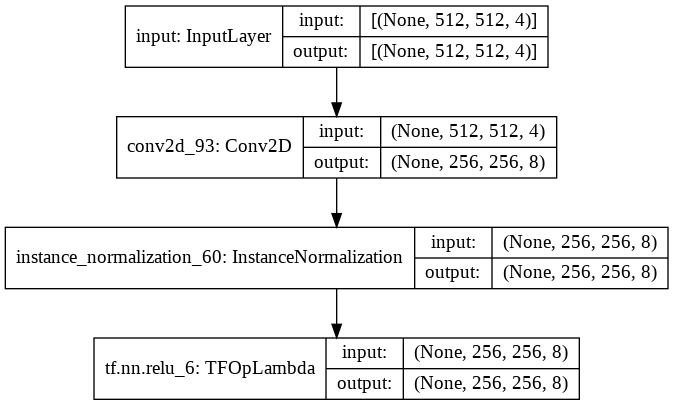

In [89]:
class DownSampleBlock(tf.keras.layers.Layer):
  def __init__(self, numOfChannels, channelExpansionFactor = 2, kernel_size = (3,3), strides = (2,2), kernel_initializer = KERNEL_INIT, gamma_initializer = GAMMA_INIT, activation = 'relu'):
    super(DownSampleBlock, self).__init__()
    
    self.activation = activation
    filters = channelExpansionFactor * numOfChannels

    self.conv = tf.keras.layers.Conv2D(
        filters, 
        kernel_size, 
        strides=strides,
        kernel_initializer = kernel_initializer,
        padding='same', 
        use_bias = False
        )
    
    self.InstNorm = tfa.layers.InstanceNormalization(
        gamma_initializer = gamma_initializer
        )
    
    self.act = tf.keras.activations.get(self.activation)

  def call(self, input_tensor):
    x = self.conv(input_tensor)
    x = self.InstNorm(x)
    x = self.act(x)
    return x


  def build_model_from_layer(self, inputDim):
    x = tf.keras.layers.Input(shape=(inputDim), name = "input")
    return tf.keras.Model(inputs=[x], outputs=self.call(x))

# Test
# Test input has the shape of the 1 training example of the dataset
dataShape = (512,512,4)
test_Input = tf.keras.layers.Input(shape=dataShape)

downBlock = DownSampleBlock(numOfChannels = dataShape[2], kernel_size = (3,3))
test_output = downBlock(test_Input)
print("Input Shape:{}".format(test_Input.shape))
print("Output Shape:{}".format(test_output.shape))
print("Expected Output Shape:(None,{},{},{})".format(int(dataShape[0]/2), int(dataShape[1]/2), int(2*dataShape[2])))

layerModel = downBlock.build_model_from_layer(dataShape)
layerModel.summary()
tf.keras.utils.plot_model(layerModel, show_shapes=True)


<a name="4-2-2"></a>
### 4.2.2 Up-Sample Model Block

Input Shape:(None, 512, 512, 4)
Output Shape:(None, 1024, 1024, 2)
Expected Output Shape:(None,1024,1024,2)
Model: "model_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 512, 512, 4)]     0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 1024, 1024, 2)     72        
_________________________________________________________________
instance_normalization_63 (I (None, 1024, 1024, 2)     4         
_________________________________________________________________
tf.nn.relu_14 (TFOpLambda)   (None, 1024, 1024, 2)     0         
Total params: 76
Trainable params: 76
Non-trainable params: 0
_________________________________________________________________


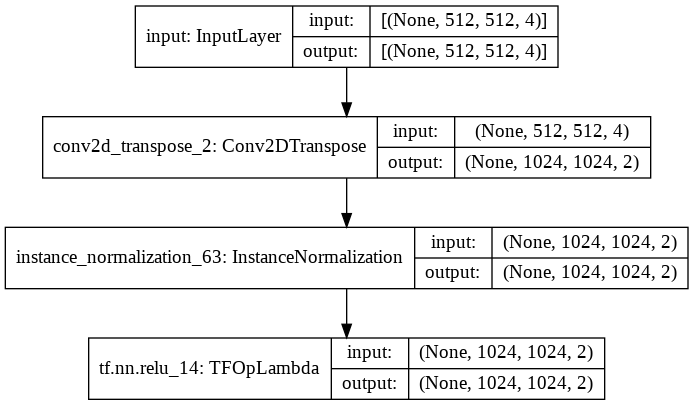

In [112]:
class UpSampleBlock(tf.keras.layers.Layer):
  def __init__(self, numOfChannels, channelReductionFactor = 2, kernel_size = (3,3), strides = (2,2), kernel_initializer = KERNEL_INIT, gamma_initializer = GAMMA_INIT, activation = 'relu'):
    super(UpSampleBlock, self).__init__()
    
    self.activation = activation
    filters = int(numOfChannels / channelReductionFactor)

    self.convTrans = tf.keras.layers.Conv2DTranspose(
        filters, 
        kernel_size, 
        strides=strides,
        kernel_initializer = kernel_initializer,
        padding='same', 
        use_bias = False
        )
    
    self.InstNorm = tfa.layers.InstanceNormalization(
        gamma_initializer = gamma_initializer
        )
    
    self.act = tf.keras.activations.get(self.activation)

  def call(self, input_tensor):
    x = self.convTrans(input_tensor)
    x = self.InstNorm(x)
    x = self.act(x)
    return x


  def build_model_from_layer(self, inputDim):
    x = tf.keras.layers.Input(shape=(inputDim), name = "input")
    return tf.keras.Model(inputs=[x], outputs=self.call(x))

# Test
# Test input has the shape of the 1 training example of the dataset
dataShape = (512,512,4)
test_Input = tf.keras.layers.Input(shape=dataShape)

upBlock = UpSampleBlock(numOfChannels = dataShape[2], kernel_size = (3,3))
test_output = upBlock(test_Input)
print("Input Shape:{}".format(test_Input.shape))
print("Output Shape:{}".format(test_output.shape))
print("Expected Output Shape:(None,{},{},{})".format(int(dataShape[0]*2), int(dataShape[1]*2), int(dataShape[2]/2)))

layerModel = upBlock.build_model_from_layer(dataShape)
layerModel.summary()
tf.keras.utils.plot_model(layerModel, show_shapes=True)

<a name="4-2-4"></a>
### 4.2.4 Residual Identity Model Block

Der unten gezeigte Residualblock unterscheidet sich noch von dem CycleGAN Beispiel...

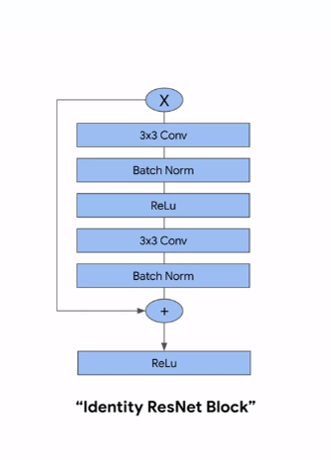

Model: "model_137"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 512, 512, 4) 0                                            
__________________________________________________________________________________________________
conv2d_932 (Conv2D)             (None, 512, 512, 4)  148         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_616 (BatchN (None, 512, 512, 4)  16          conv2d_932[0][0]                 
__________________________________________________________________________________________________
tf.nn.relu_23 (TFOpLambda)      (None, 512, 512, 4)  0           batch_normalization_616[0][0]    
__________________________________________________________________________________________

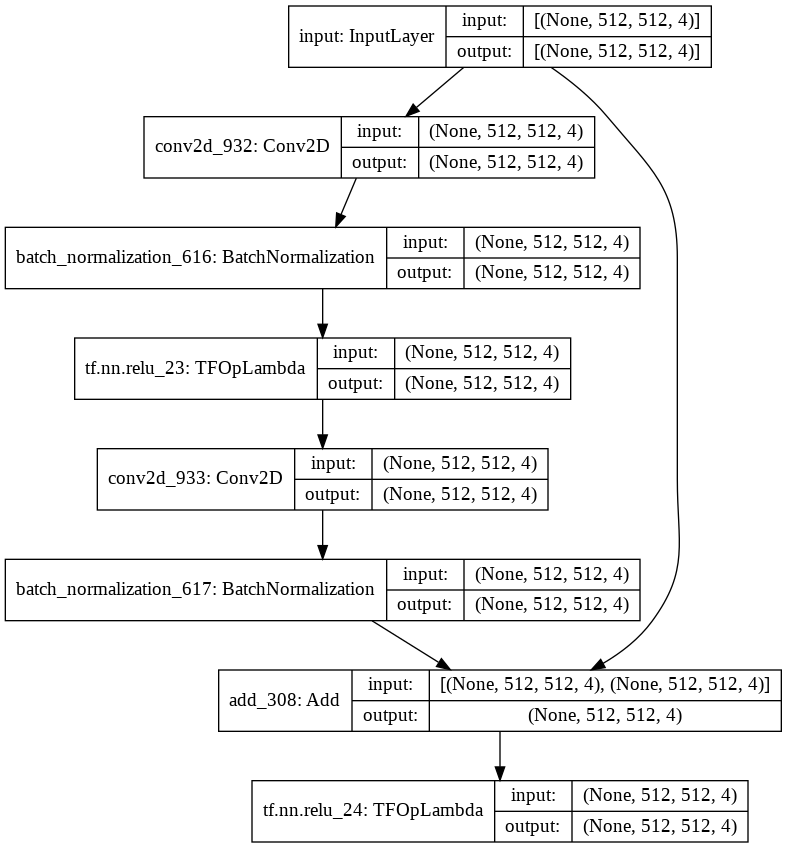

In [196]:
class ResidualIdentityBlock(tf.keras.layers.Layer):
  def __init__(self, filters, kernel_size, strides = (1,1), activation = 'relu'):
    super(ResidualIdentityBlock, self).__init__()

    self.activation = activation

    self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, strides, padding = 'same')
    self.bn1 = tf.keras.layers.BatchNormalization()


    self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, strides, padding = 'same')
    self.bn2 = tf.keras.layers.BatchNormalization()

    self.add = tf.keras.layers.Add()
    

  def call(self, input_tensor):
    x = self.conv1(input_tensor)
    x = self.bn1(x)
    x = tf.keras.activations.get(self.activation)(x)

    x = self.conv2(x)
    x = self.bn2(x)

    x = self.add([x, input_tensor])
    x = tf.keras.activations.get(self.activation)(x)

    return x

  def build_model_from_layer(self, inputDim):
    x = tf.keras.layers.Input(shape=(inputDim), name = "input")
    return tf.keras.Model(inputs=[x], outputs=self.call(x))

# Test Code
# Test input has the shape of the 1 training example of the dataset
dataShape = (512,512,4)
test_Input = tf.keras.layers.Input(shape=dataShape)

resnetBlock = ResidualIdentityBlock(filters = 4, kernel_size = (3,3), activation = 'relu')

layerModel = resnetBlock.build_model_from_layer(dataShape)
layerModel.summary()
tf.keras.utils.plot_model(layerModel, show_shapes=True)


<a name="4-3"></a>
## 4.3 Custom Losses

<a name="4-4"></a>
## 4.4 Custom Model

<a name="4-4-1"></a>
### 4.4.1 U-Net

Model: "model_173"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_323 (InputLayer)          [(None, 512, 512, 4) 0                                            
__________________________________________________________________________________________________
down_sample_block_347 (DownSamp (None, 256, 256, 8)  304         input_323[0][0]                  
__________________________________________________________________________________________________
down_sample_block_348 (DownSamp (None, 128, 128, 16) 1184        down_sample_block_347[0][0]      
__________________________________________________________________________________________________
down_sample_block_349 (DownSamp (None, 64, 64, 32)   4672        down_sample_block_348[0][0]      
__________________________________________________________________________________________

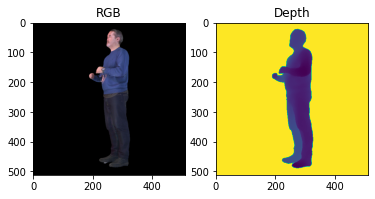

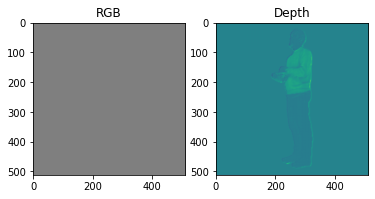

In [220]:
class UNet(tf.keras.Model):
  def __init__(self, filters = 4, num_up_down_blocks = 4, kernel_initializer = KERNEL_INIT): #TODO: add missing arguments
    super(UNet, self).__init__()
    
    #double the filtersize with ervery downsample step
    self.downBlocks = [DownSampleBlock(filters * (2**x) ) for x in range(num_up_down_blocks)]
    
    #filter size is reduced with every upsampling step. Note that range is reversed!
    self.upBlocks = [UpSampleBlock(filters * (2**(x+1))) for x in reversed(range(num_up_down_blocks))]

    # las layer is to get the original image shape back. Without there are 8 channels not 4 due to the concat!!
    self.finalLayer = tf.keras.layers.Conv2DTranspose(filters, 4, strides=2, kernel_initializer = kernel_initializer, padding='same', activation='sigmoid' )


  def call(self, input_tensor):
    x = input_tensor
    
    # store skip connections during down sampling, and concatenate during upsampling
    skips = []

    #Downsampling Blocks
    for down in self.downBlocks:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(self.upBlocks, skips):
      x = up(x)
      x = tf.keras.layers.Concatenate()([x, skip])

    x = self.finalLayer(x)

    return x

  def build_model_from_layers(self, shape):
    x = tf.keras.layers.Input(shape=(shape))
    return tf.keras.Model(inputs=[x], outputs=self.call(x))

# Test Code
# Test input has the shape of the 1 training example of the dataset
dataShape = (512, 512, 4)
test_Input = tf.keras.layers.Input(shape=dataShape)

UNet = UNet(filters = dataShape[2] ,num_up_down_blocks = 4)
UNet.build_model_from_layers(dataShape).summary()
tf.keras.utils.plot_model(UNet.build_model_from_layers(dataShape), show_shapes=True, expand_nested=True)

# Test forward Propagation
#rgbd_samples = Combine_color_depth(DATA_PATH)
#Plot_RGBD_Sample(rgbd_samples[24,:,:,:])
#output = UNet(rgbd_samples, training = False)
#Plot_RGBD_Sample(output[24,:,:,:])
#print(output)
  

<a name="4-4-2"></a>
### 4.4.2 ResNet



Model: "model_199"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_350 (InputLayer)       [(None, 512, 512, 4)]     0         
_________________________________________________________________
down_sample_block_399 (DownS (None, 256, 256, 8)       304       
_________________________________________________________________
down_sample_block_400 (DownS (None, 128, 128, 16)      1184      
_________________________________________________________________
down_sample_block_401 (DownS (None, 64, 64, 32)        4672      
_________________________________________________________________
down_sample_block_402 (DownS (None, 32, 32, 64)        18560     
_________________________________________________________________
residual_identity_block_356  (None, 32, 32, 64)        74368     
_________________________________________________________________
residual_identity_block_357  (None, 32, 32, 64)        74

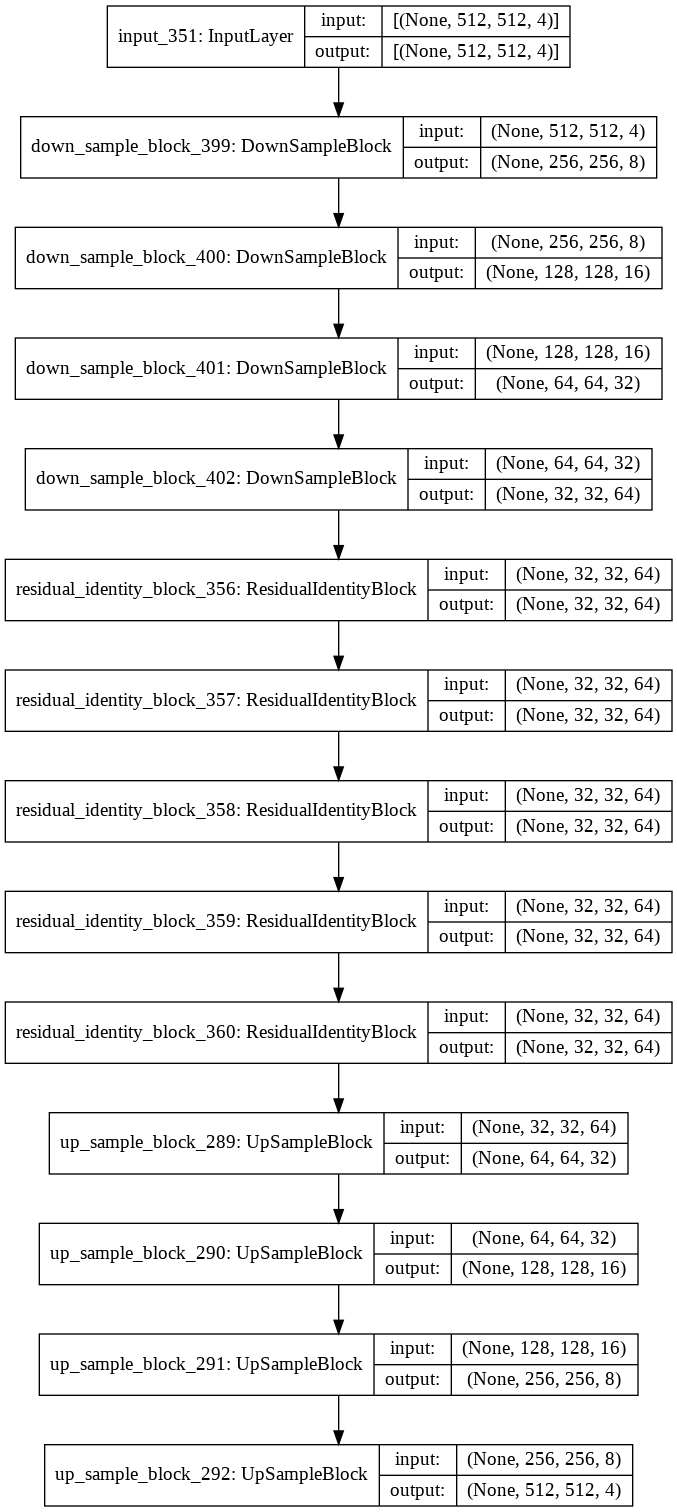

In [233]:
class ResNet(tf.keras.Model):
  def __init__(self, filters = 4, num_up_down_blocks = 4, num_res_blocks = 5, weight_sharing_active = False):
    super(ResNet, self).__init__()
    self.num_res_blocks = num_res_blocks
    self.weight_sharing_active = weight_sharing_active
    #self.num_up_down_blocks = num_up_down_blocks

    #double the filtersize with ervery downsample step
    self.downBlocks = [DownSampleBlock(filters * (2**x) ) for x in range(num_up_down_blocks)]

    #--------------------------------------------------
    #filter size after all downsampling steps
    filterSizeResBlock = filters * (2**num_up_down_blocks)
    if (weight_sharing_active):
      self.resBlocks = ResidualIdentityBlock(filterSizeResBlock, kernel_size =(3,3))
    else:
      self.resBlocks = [ResidualIdentityBlock(filterSizeResBlock, kernel_size = (3,3)) for _ in range(num_res_blocks)]
    #--------------------------------------------------
    
    #filter size is reduced with every upsampling step. Note that range is reversed!
    self.upBlocks = [UpSampleBlock(filters * (2**(x+1))) for x in reversed(range(num_up_down_blocks))]


  def call(self, input_tensor):
    x = input_tensor

    #Downsampling Blocks
    for down in self.downBlocks:
        x = down(x)

    #Residual Blocks
    if (self.weight_sharing_active):
      for _ in range(0,self.num_res_blocks):
        x = self.resBlocks(x)
    else:
      for layer in self.resBlocks:
        x = layer(x)

    # Upsampling Blocks
    for up in self.upBlocks:
        x = up(x)

    return x

  def build_model_from_layers(self, shape):
    x = tf.keras.layers.Input(shape=(shape))
    return tf.keras.Model(inputs=[x], outputs=self.call(x))

# Test Code
# Test input has the shape of the 1 training example of the dataset
dataShape = (512, 512, 4)
test_Input = tf.keras.layers.Input(shape=dataShape)

ResNet = ResNet(filters = dataShape[2] ,num_res_blocks = 5, weight_sharing_active = False)
ResNet.build_model_from_layers(dataShape).summary()
tf.keras.utils.plot_model(ResNet.build_model_from_layers(dataShape), show_shapes=True, expand_nested=True)

# Test forward Propagation
#rgbd_samples = Combine_color_depth(DATA_PATH)
#Plot_RGBD_Sample(rgbd_samples[24,:,:,:])
#output = ResNet(rgbd_samples, training = False)
#Plot_RGBD_Sample(output[24,:,:,:])
#print(output)

<a name="4-4-3"></a>
### 4.4.3 PatchGAN Discriminator

The PatchGAN has been used in the Pix2Pix model: https://www.tensorflow.org/tutorials/generative/pix2pix

Model: "model_223"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_synthetic (InputLayer)    [(None, 512, 512, 4) 0                                            
__________________________________________________________________________________________________
input_target (InputLayer)       [(None, 512, 512, 4) 0                                            
__________________________________________________________________________________________________
concatenate_163 (Concatenate)   (None, 512, 512, 8)  0           input_synthetic[0][0]            
                                                                 input_target[0][0]               
__________________________________________________________________________________________________
down_sample_block_447 (DownSamp (None, 256, 256, 8)  592         concatenate_163[0][0]    

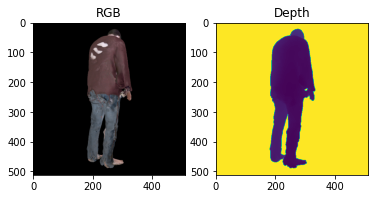

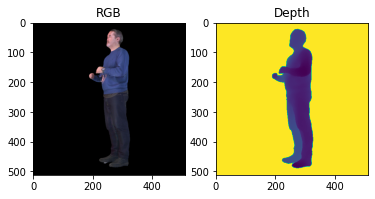

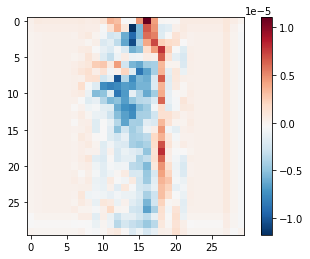

In [245]:
class PatchGAN(tf.keras.Model):
  def __init__(self, filters = 4, num_up_down_blocks = 4, kernel_initializer = KERNEL_INIT):
    super(PatchGAN, self).__init__()
    
    self.concat = tf.keras.layers.Concatenate()
    
    self.downBlocks = [DownSampleBlock(filters * (2**x) ) for x in range(num_up_down_blocks)]
    self.zeroPadding1 = tf.keras.layers.ZeroPadding2D()

    # convolution doubles number of filters, while roughly maintaining height/width (no padding, therfore roughly)
    self.conv1 = tf.keras.layers.Conv2D(filters * (2**(num_up_down_blocks + 1)), 4, strides=1, kernel_initializer = kernel_initializer, use_bias=False)
    
    self.batchNorm = tf.keras.layers.BatchNormalization()
    self.act = tf.keras.layers.LeakyReLU()

    self.zeroPadding2 = tf.keras.layers.ZeroPadding2D()

    #everthing down to one channel
    self.conv2 = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer = kernel_initializer)

  def call(self, input_synthetic, input_target):
    x = self.concat([input_synthetic,input_target])
    #Downsampling Blocks
    for down in self.downBlocks:
        x = down(x)
    x = self.zeroPadding1(x)
    x = self.conv1(x)
    x = self.batchNorm(x)
    x = self.act(x)
    x = self.zeroPadding2(x)
    x = self.conv2(x)
    
    return x


  def build_model_from_layers(self, inputDim):
    x = tf.keras.layers.Input(shape=(inputDim), name = "input_synthetic")
    y = tf.keras.layers.Input(shape=(inputDim), name = "input_target")
    return tf.keras.Model(inputs=[x, y], outputs=self.call(x,y))

# Test
# Test input has the shape of the 1 training example of the dataset
dataShape = (512,512,4)
test_Input = tf.keras.layers.Input(shape=dataShape)

patchGAN = PatchGAN(num_up_down_blocks = 4)
patchGAN.build_model_from_layers(dataShape).summary()
tf.keras.utils.plot_model(patchGAN.build_model_from_layers(dataShape), show_shapes=True, expand_nested=True)

# Test forward Propagation
#rgbd_samples = Combine_color_depth(DATA_PATH)
img1 = rgbd_samples[29,:,:,:]
img2 = rgbd_samples[24,:,:,:]
Plot_RGBD_Sample(img1)
Plot_RGBD_Sample(img2)
output = patchGAN(img1[tf.newaxis,...], img2[tf.newaxis,...], training = False)
plt.imshow(output[0,...,-1], cmap='RdBu_r')
plt.colorbar()
#print(output)

<a name="4-4-4"></a>
### 4.4.4 CycleGAN

<a name="4-2"></a>
## 4.2 Custom Callbacks

<a name="5"></a>
# 5. Training the Model

<a name="6"></a>
# 6. Validating the Model

<a name="A"></a>
# A. TESTING AND DEBUGGING

In [ ]:
#Prepare_filename(directory):
rgbd_samples = Combine_color_depth(DATA_PATH)
Plot_RGBD_Sample(rgbd_samples[24,:,:,:])
Plot_Multiple_RGBD(rgbd_samples)
#Create_tensorflow_dataset(rgbd_samples)